# Begining of Life

The purpose of this notebook is to establish basic beginning of life parameters of this concept including $k_{eff}$ and neutron energy spectrum.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3206e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.8230e-4)
fuel.add_nuclide('U238',1.1363e-3)
fuel.add_element('C',7.5500e-2)
fuel.add_element('O',2.8371e-3)
fuel.add_element('S',3.4500e-3)
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.1

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = coolant
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

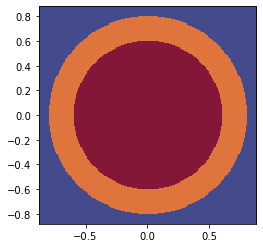

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")
power = 1e4;
days = 24*3600;
time_steps = [0.1*days, 0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days,365.*days,365.*days,365.*days,730.*days,730.*days]
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr52.h5
 Reading Cr5

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5


          1200K


 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.03950
        2/1    1.02302
        3/1    1.02367
        4/1    1.03653
        5/1    1.03966
        6/1    1.03027
        7/1    1.02017
        8/1    1.03430
        9/1    1.02425
       10/1    1.01922
       11/1    1.02248
       12/1    1.01713
       13/1    1.02286
       14/1    1.02520
       15/1    1.04785
       16/1    1.04134
       17/1    1.03650
       18/1    1.03031
       19/1    1.03576
       20/1    1.01397
       21/1    1.02142
       22/1    1.02541
       23/1    1.03898
       24/1    1.02654
       25/1    1.02371
       26/1    1.02084
       27/1    1.01848
       28/1    1.03070
       29/1    1.02144
       30/1    1.02166
       31/1    1.03122
       32/1    1.05183
       33/1    1.03198
       34/1    1.03443
       35/1    1.03

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.04242
        2/1    1.01605
        3/1    1.02283
        4/1    1.03784
        5/1    1.02719
        6/1    1.00418
        7/1    1.04181
        8/1    1.03568
        9/1    1.02997
       10/1    1.03624
       11/1    1.01103
       12/1    1.03998
       13/1    1.01974
       14/1    1.02345
       15/1    1.02868
       16/1    1.02135
       17/1    1.02771
       18/1    1.01954
       19/1    1.02675
       20/1    1.04426
       21/1    1.02954
       22/1    1.02504
       23/1    1.02720
       24/1    1.02822
       25/1    1.02240
       26/1    1.02554
       27/1    1.02760
       28/1    1.02728
       29/1    1.03534
       30/1    1.03517
       31/1    1.02262
       32/1    1.03707
       33/1    1.02116
       34/1    1.01171
       35/1    1.01

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.02623
        2/1    1.02314
        3/1    1.02218
        4/1    1.04073
        5/1    1.03653
        6/1    1.02849
        7/1    1.02842
        8/1    1.03027
        9/1    1.03050
       10/1    1.03526
       11/1    1.02371
       12/1    1.03207
       13/1    1.03752
       14/1    1.01971
       15/1    1.03086
       16/1    1.02992
       17/1    1.02168
       18/1    1.02502
       19/1    1.03713
       20/1    1.03679
       21/1    1.02230
       22/1    1.00985
       23/1    1.03552
       24/1    1.04179
       25/1    1.03190
       26/1    1.03133
       27/1    1.04225
       28/1    1.03084
       29/1    1.04132
       30/1    1.01417
       31/1    1.02855
       32/1    1.03072
       33/1    1.03245
       34/1    1.03402
       35/1    1.01

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01407
        2/1    1.01812
        3/1    1.03168
        4/1    1.03513
        5/1    1.02035
        6/1    1.03114
        7/1    1.01557
        8/1    1.01878
        9/1    1.03978
       10/1    1.02544
       11/1    1.02926
       12/1    1.02371
       13/1    1.02541
       14/1    1.01878
       15/1    1.01750
       16/1    1.03954
       17/1    1.03626
       18/1    1.01814
       19/1    1.02157
       20/1    1.04010
       21/1    1.03207
       22/1    1.03271
       23/1    1.02525
       24/1    1.02459
       25/1    1.03889
       26/1    1.03342
       27/1    1.03251
       28/1    1.02152
       29/1    1.02159
       30/1    1.03179
       31/1    1.02895
       32/1    1.03662
       33

      200/1    1.02706    1.02753 +/- 0.00068
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 4.0766e+03 seconds
   Time in transport only          = 4.0757e+03 seconds
   Time in inactive batches        = 5.9117e+02 seconds
   Time in active batches          = 3.4854e+03 seconds
   Time synchronizing fission bank = 6.0097e-01 seconds
     Sampling source sites         = 5.4678e-01 seconds
     SEND/RECV source sites        = 5.2974e-02 seconds
   Time accumulating tallies       = 3.6694e-02 seconds
   Time writing statepoints        = 1.6836e-02 seconds
 Total time for finalization       = 2.2356e-03 seconds
 Total time elapsed                = 4.0770e+03 seconds
 Calculation Rate (inactive)       = 1691.57 particles/second
 Calculation Rate (active)         = 860.7

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.02684
        2/1    1.01194
        3/1    1.02919
        4/1    1.02526
        5/1    1.02825
        6/1    1.04367
        7/1    1.03336
        8/1    1.03382
        9/1    1.02189
       10/1    1.02086
       11/1    1.02012
       12/1    1.03104
       13/1    1.01657
       14/1    1.01993
       15/1    1.03139
       16/1    1.02592
       17/1    1.03909
       18/1    1.03733
       19/1    1.02758
       20/1    1.01754
       21/1    1.02234
       22/1    1.03538
       23/1    1.03352
       24/1    1.02655
       25/1    1.02787
       26/1    1.03696
       27/1    1.01728
       28/1    1.02969
       29/1    1.01920
       30/1    1.04855
       31/1    1.04046
       32/1    1.04488
       33/1    1.02576
       34/1    1.02104
       35/1    1.02

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.03034
        2/1    1.02499
        3/1    1.02306
        4/1    1.02450
        5/1    1.01648
        6/1    1.02751
        7/1    1.02285
        8/1    1.02161
        9/1    1.02010
       10/1    1.01686
       11/1    1.01002
       12/1    1.01732
       13/1    1.02145
       14/1    1.03492
       15/1    1.00468
       16/1    1.03215
       17/1    1.02653
       18/1    1.01623
       19/1    1.02169
       20/1    1.02166
       21/1    1.03838
       22/1    1.01783
       23/1    1.02760
       24/1    1.02723
       25/1    1.01473
       26/1    1.03084
       27/1    1.02246
       28/1    1.01395
       29/1    1.02566
       30/1    1.04122
       31/1    1.03025
       32/1    1.02000
       33/1    1.03693
       34/1    1.01958
       35/1    1.02

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00943
        2/1    1.02852
        3/1    1.00368
        4/1    1.01786
        5/1    1.01715
        6/1    1.01104
        7/1    1.02220
        8/1    1.02008
        9/1    1.00211
       10/1    1.01269
       11/1    1.01061
       12/1    1.00796
       13/1    1.01646
       14/1    1.01031
       15/1    1.02590
       16/1    1.03461
       17/1    1.02081
       18/1    1.02608
       19/1    1.00849
       20/1    1.02202
       21/1    1.00361
       22/1    1.01355
       23/1    1.00947
       24/1    1.01623
       25/1    1.01570
       26/1    1.01665
       27/1    1.02465
       28/1    1.02299
       29/1    1.02516
       30/1    1.01769
       31/1    1.02071
       32/1    1.02692
       33/1    1.01495
       34/1    1.02010
       35/1    1.02

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01521
        2/1    1.01363
        3/1    1.01391
        4/1    1.00988
        5/1    1.01350
        6/1    1.00031
        7/1    1.01900
        8/1    0.99869
        9/1    1.00962
       10/1    1.01368
       11/1    1.01371
       12/1    1.01176
       13/1    1.01609
       14/1    1.00523
       15/1    1.01703
       16/1    0.99971
       17/1    1.01569
       18/1    1.01079
       19/1    1.00293
       20/1    0.99515
       21/1    1.00668
       22/1    1.00546
       23/1    1.00998
       24/1    1.00688
       25/1    1.00802
       26/1    1.01095
       27/1    1.01189
       28/1    1.00631
       29/1    1.01031
       30/1    0.99863
       31/1    1.01684
       32/1    1.02194
       33/1    1.01620
       34/1    0.99831
       35/1    1.00

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99061
        2/1    0.98600
        3/1    0.98636
        4/1    0.98502
        5/1    0.98890
        6/1    0.97119
        7/1    0.98187
        8/1    0.98550
        9/1    0.98102
       10/1    0.98495
       11/1    0.98754
       12/1    0.98617
       13/1    0.98064
       14/1    0.99135
       15/1    0.97214
       16/1    0.98569
       17/1    0.97874
       18/1    0.98086
       19/1    0.99194
       20/1    0.98334
       21/1    0.98703
       22/1    0.97897
       23/1    0.98472
       24/1    0.98261
       25/1    0.97444
       26/1    0.99570
       27/1    0.98431
       28/1    0.98698
       29/1    0.98395
       30/1    0.99594
       31/1    0.99989
       32/1    0.98314
       33/1    0.98067
       34/1    0.98098
       35/1    0.97

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.91023
        2/1    0.91459
        3/1    0.90544
        4/1    0.89954
        5/1    0.91094
        6/1    0.90572
        7/1    0.90857
        8/1    0.90377
        9/1    0.89661
       10/1    0.90384
       11/1    0.91743
       12/1    0.91014
       13/1    0.89909
       14/1    0.90746
       15/1    0.90033
       16/1    0.89642
       17/1    0.89908
       18/1    0.89670
       19/1    0.90027
       20/1    0.90248
       21/1    0.90355
       22/1    0.90999
       23/1    0.91290
       24/1    0.91479
       25/1    0.90537
       26/1    0.90747
       27/1    0.90998
       28/1    0.91018
       29/1    0.91357
       30/1    0.91075
       31/1    0.90356
       32/1    0.90089
       33/1    0.90425
       34/1    0.89857
       35/1    0.91

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.85582
        2/1    0.85925
        3/1    0.84076
        4/1    0.85213
        5/1    0.85786
        6/1    0.86478
        7/1    0.85150
        8/1    0.85182
        9/1    0.85588
       10/1    0.85783
       11/1    0.83907
       12/1    0.85367
       13/1    0.84902
       14/1    0.85398
       15/1    0.85107
       16/1    0.84395
       17/1    0.85744
       18/1    0.85506
       19/1    0.85616
       20/1    0.86646
       21/1    0.85750
       22/1    0.85516
       23/1    0.85427
       24/1    0.85900
       25/1    0.84980
       26/1    0.84816
       27/1    0.85202
       28/1    0.85689
       29/1    0.85284
       30/1    0.84317
       31/1    0.85621
       32/1    0.85418
       33/1    0.86233
       34/1    0.84783
       35/1    0.86

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.80696
        2/1    0.82523
        3/1    0.81655
        4/1    0.81244
        5/1    0.81490
        6/1    0.82415
        7/1    0.81911
        8/1    0.82679
        9/1    0.80710
       10/1    0.81325
       11/1    0.81320
       12/1    0.81584
       13/1    0.82092
       14/1    0.81456
       15/1    0.81074
       16/1    0.81214
       17/1    0.81259
       18/1    0.81909
       19/1    0.80989
       20/1    0.81465
       21/1    0.82358
       22/1    0.80327
       23/1    0.82156
       24/1    0.80862
       25/1    0.80934
       26/1    0.81896
       27/1    0.81754
       28/1    0.81262
       29/1    0.81761
       30/1    0.81597
       31/1    0.82532
       32/1    0.80383
       33/1    0.81090
       34/1    0.81762
       35/1    0.81

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.76068
        2/1    0.75993
        3/1    0.76048
        4/1    0.76086
        5/1    0.76309
        6/1    0.76109
        7/1    0.75922
        8/1    0.75945
        9/1    0.75893
       10/1    0.76833
       11/1    0.76215
       12/1    0.75902
       13/1    0.76165
       14/1    0.75941
       15/1    0.76754
       16/1    0.76283
       17/1    0.77089
       18/1    0.76056
       19/1    0.76656
       20/1    0.75753
       21/1    0.76381
       22/1    0.77035
       23/1    0.76662
       24/1    0.76579
       25/1    0.75894
       26/1    0.76248
       27/1    0.76086
       28/1    0.76353
       29/1    0.76565
       30/1    0.75660
       31/1    0.76431
       32/1    0.77102
       33/1    0.76432
       34/1    0.75738
       35/1    0.76

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.71985
        2/1    0.72827
        3/1    0.72556
        4/1    0.72729
        5/1    0.72430
        6/1    0.72092
        7/1    0.72895
        8/1    0.72332
        9/1    0.72324
       10/1    0.73091
       11/1    0.73942
       12/1    0.73014
       13/1    0.71989
       14/1    0.72182
       15/1    0.72687
       16/1    0.72717
       17/1    0.72164
       18/1    0.72399
       19/1    0.72405
       20/1    0.72449
       21/1    0.72482
       22/1    0.72976
       23/1    0.71998
       24/1    0.72114
       25/1    0.72371
       26/1    0.72406
       27/1    0.72247
       28/1    0.72087
       29/1    0.72257
       30/1    0.71698
       31/1    0.72065
       32/1    0.71680
       33/1    0.72221
       34/1    0.72195
       35/1    0.72

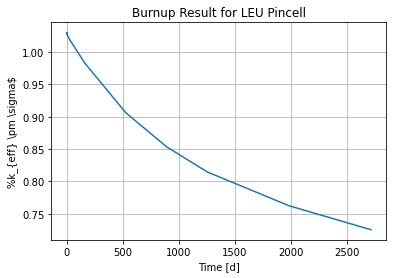

In [8]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

time,k = results.get_eigenvalue()
time /= (24*60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for LEU Pincell')
plt.xlabel('Time [d]')
plt.ylabel('%k_{eff} \pm \sigma$')
plt.grid()



Text(0, 0.5, 'Number of atoms Cs137')

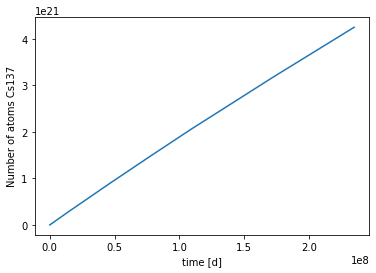

In [9]:
time, cs137 = results.get_atoms("1","Cs137")# I should verify that fuel is material "1"
plt.plot(time,cs137,label="Cs137")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Cs137")

Text(0, 0.5, 'Number of atoms Pu239')

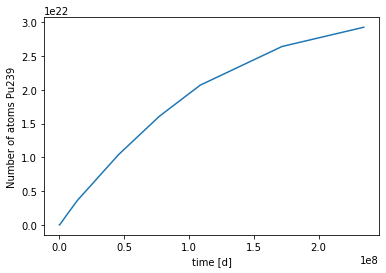

In [10]:
time, Pu239 = results.get_atoms("1","Pu239")
plt.plot(time,Pu239,label="Pu239")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Pu239")

Text(0, 0.5, 'Number of atoms')

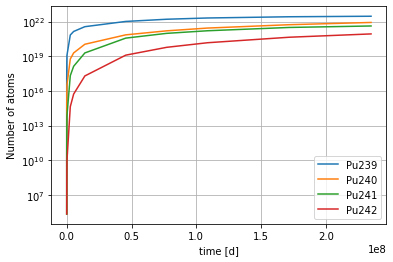

In [11]:
time, Pu240 = results.get_atoms("1","Pu240")
time, Pu241 = results.get_atoms("1","Pu241")
time, Pu242 = results.get_atoms("1","Pu242")

plt.semilogy(time,Pu239,label="Pu239")
plt.semilogy(time,Pu240,label="Pu240")
plt.semilogy(time,Pu241,label="Pu241")
plt.semilogy(time,Pu242,label="Pu242")
plt.legend()
plt.grid()
plt.xlabel("time [d]")
plt.ylabel("Number of atoms")